# おもちゃのブロックの不良検出


# VGG16＋one_class_SVM

## １　ドライブのマウント

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# 現在の作業ディレクトリのファイル一覧を変数filesに代入し、一覧を表示
import os
files = os.listdir('./')
print(files)


['.config', 'drive', 'sample_data']


#２  画像データの取り込み

### 良品の画像の確認

In [3]:
import os
from PIL import Image
import matplotlib.pyplot as plt

# Google Drive内の画像フォルダへのパス
train_image_folder_path = '/content/drive/MyDrive/Mago_Serise/mago79(one_class SVM)/CQsemi/images/ok/'

# 画像フォルダ内のファイルをリストアップ
image_files = os.listdir(train_image_folder_path)
print(len(image_files))

# 最初の10枚の画像を横に5枚ずつ表示
num_images = min(len(image_files), 10)
num_rows = (num_images + 4) // 5  # 5列に並べるための行数を計算

fig, axes = plt.subplots(num_rows, 5, figsize=(20, 4*num_rows))

for i, ax in enumerate(axes.flat):
    if i < num_images:
        image_path = os.path.join(train_image_folder_path, image_files[i])
        img = Image.open(image_path)
        ax.imshow(img)
        ax.axis('off')
    else:
        ax.axis('off')

plt.tight_layout()
plt.show()


Output hidden; open in https://colab.research.google.com to view.

### 良品の画像の輪郭抽出


In [8]:
import os
import cv2
from google.colab.patches import cv2_imshow

def preprocess_and_extract_objects(input_folder, output_folder):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for filename in os.listdir(input_folder):
        if filename.endswith(('.jpg', '.jpeg', '.png', '.bmp')):
            image_path = os.path.join(input_folder, filename)
            image = cv2.imread(image_path)

            # 画像の高さと幅を取得
            height, width = image.shape[:2]

            # 上下15％の領域を無視して中央部分を切り抜く
            ignore_top = int(height * 0.15)
            ignore_bottom = int(height * 0.85)
            central_image = image[ignore_top:ignore_bottom, :]

            # グレースケール変換
            gray = cv2.cvtColor(central_image, cv2.COLOR_BGR2GRAY)

            # 画像を二値化
            blurred = cv2.GaussianBlur(gray, (3, 3), 0)
            im2 = cv2.threshold(blurred, 200, 255, cv2.THRESH_BINARY)[1]  # 二値化の閾値を変更

            # 輪郭を抽出
            cnts = cv2.findContours(im2, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)[0]

            # 抽出した輪郭を単純なリストに変換
            result = []
            for pt in cnts:
                x, y, w, h = cv2.boundingRect(pt)
                # 大きすぎる小さすぎる領域を除去
                if not(100 < w < 300): continue
                result.append([x, y, w, h])

            # 抽出した輪郭が左側から並ぶようソート
            result = sorted(result, key=lambda x: x[0])

            # 抽出した輪郭が近すぎるものを除去
            result2 = []
            lastx = 100
            for x, y, w, h in result:
                if abs(x - lastx) < 0: continue
                ww = w // 20
                hh = h // 20
                result2.append([x, y, w, h, ww, hh])
                lastx = x

            for x, y, w, h, ww, hh in result2:
                # 切り抜き範囲を計算
                x_start = max(0, x - ww)
                y_start = max(0, y - hh + ignore_top)  # 上端のオフセットを加える
                x_end = min(image.shape[1], x + w + ww)
                y_end = min(image.shape[0], y + h + hh + ignore_top)  # 上端のオフセットを加える

                # 切り抜き
                object_image = image[y_start:y_end, x_start:x_end]

                # 保存
                object_output_path = os.path.join(output_folder, "object_" + filename)
                cv2.imwrite(object_output_path, object_image)
                # print(f"{filename}: 物体の画像が保存されました。")

    print("すべての画像の処理が完了しました。")

if __name__ == '__main__':
    train_input_folder = '/content/drive/MyDrive/Mago_Serise/mago79(one_class SVM)/CQsemi/images/ok/'
    train_output_folder = '/content/drive/MyDrive/Mago_Serise/mago79(one_class SVM)/CQsemi/images/ok_d/'
    preprocess_and_extract_objects(train_input_folder, train_output_folder)



すべての画像の処理が完了しました。


### 良品の輪郭抽出した画像の確認


In [11]:
# 画像フォルダ内のファイルをリストアップ
image_files = os.listdir(train_output_folder)
num=100
# 最初の100枚の画像を横に5枚ずつ表示
num_images = min(len(image_files), num)
print(len(image_files))

num_rows = (num_images + 4) // 5  # 5列に並べるための行数を計算

fig, axes = plt.subplots(num_rows, 5, figsize=(20, 4*num_rows))

for i, ax in enumerate(axes.flat):
    if i < num_images:
        image_path = os.path.join(train_output_folder, image_files[i])
        img = Image.open(image_path)
        ax.imshow(img)
        ax.axis('off')
    else:
        ax.axis('off')

plt.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

### テスト画像の確認


In [12]:
# Google Drive内の画像フォルダへのパス
test_image_folder_path = '/content/drive/MyDrive/Mago_Serise/mago79(one_class SVM)/CQsemi/images/test_img/'

# 画像フォルダ内のファイルをリストアップ
image_files = os.listdir(test_image_folder_path)

# 最初の10枚の画像を横に5枚ずつ表示
num_images = min(len(image_files), 100)
print(len(image_files))
num_rows = (num_images + 4) // 5  # 5列に並べるための行数を計算

fig, axes = plt.subplots(num_rows, 5, figsize=(20, 4*num_rows))

for i, ax in enumerate(axes.flat):


    if i < num_images:
        image_path = os.path.join(test_image_folder_path, image_files[i])
        img = Image.open(image_path)
        ax.imshow(img)
        ax.axis('off')
    else:
        ax.axis('off')

plt.tight_layout()
plt.show()


Output hidden; open in https://colab.research.google.com to view.

### テスト画像の輪郭抽出と確認

In [13]:
test_input_folder = '/content/drive/MyDrive/Mago_Serise/mago79(one_class SVM)/CQsemi/images/test_img/'
test_output_folder = '/content/drive/MyDrive/Mago_Serise/mago79(one_class SVM)/CQsemi/images/test_img_d/'
preprocess_and_extract_objects(test_input_folder, test_output_folder)

すべての画像の処理が完了しました。


9


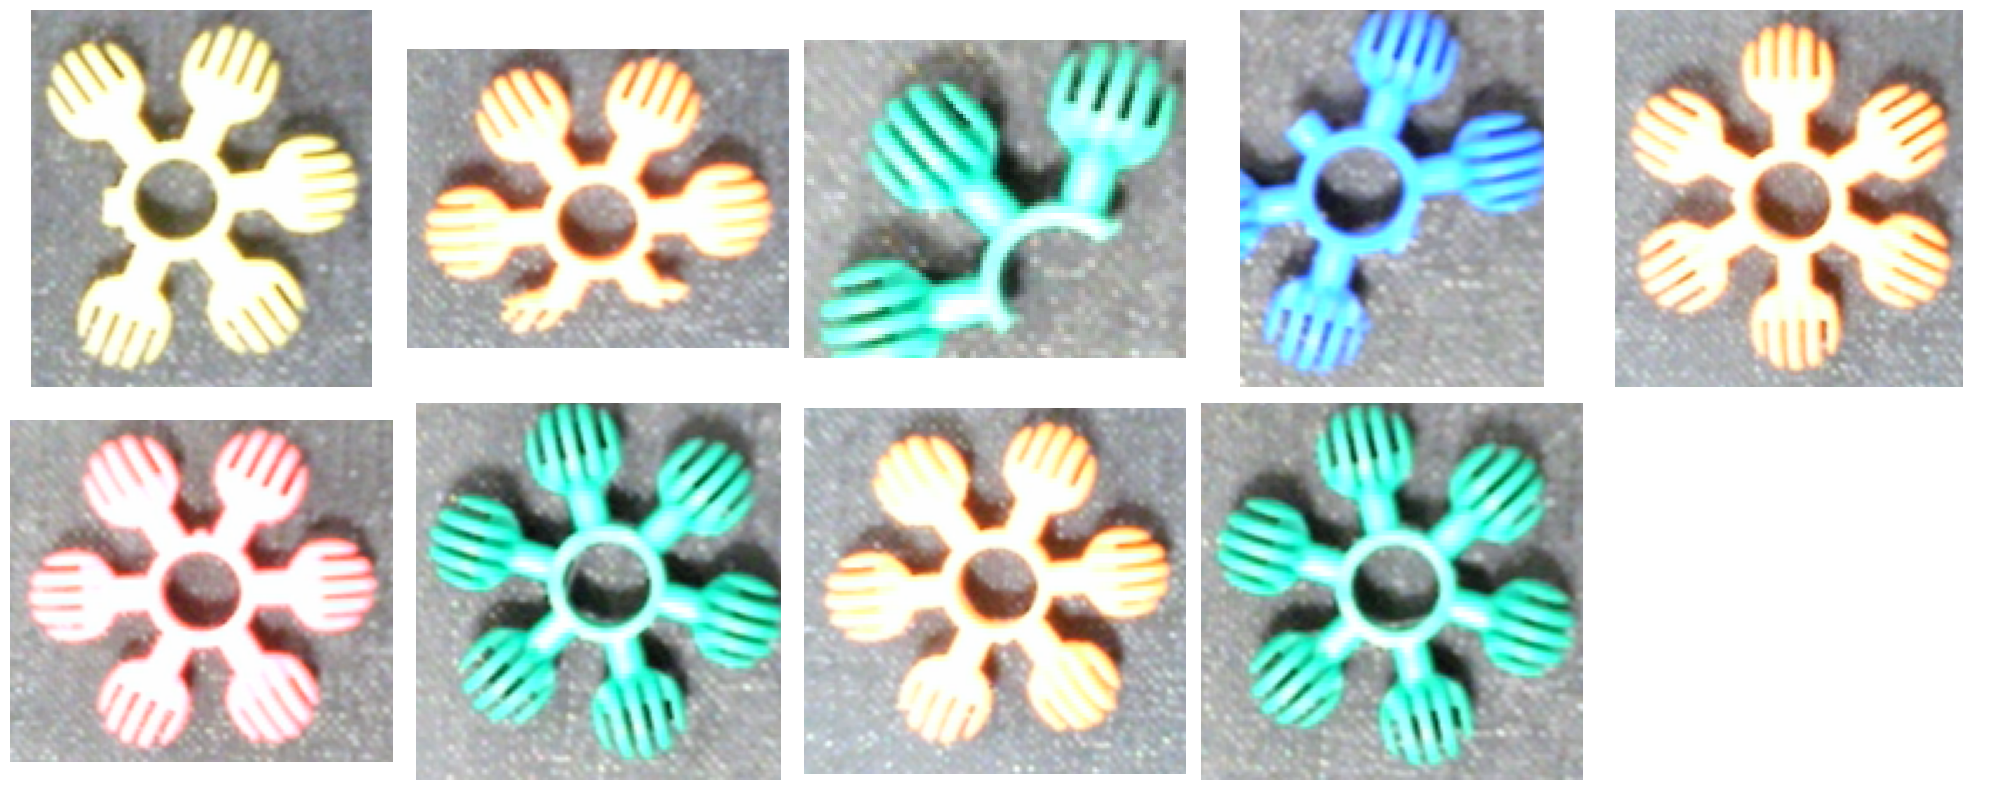

In [14]:

# 画像フォルダ内のファイルをリストアップ
image_files = os.listdir(test_output_folder)
num=100
# 最初の100枚の画像を横に5枚ずつ表示
num_images = min(len(image_files), num)
print(len(image_files))

num_rows = (num_images + 4) // 5  # 5列に並べるための行数を計算

fig, axes = plt.subplots(num_rows, 5, figsize=(20, 4*num_rows))

for i, ax in enumerate(axes.flat):
    if i < num_images:
        image_path = os.path.join(test_output_folder, image_files[i])
        img = Image.open(image_path)
        ax.imshow(img)
        ax.axis('off')
    else:
        ax.axis('off')

plt.tight_layout()
plt.show()

###良品の画像のリサイズと水増し


In [15]:
import cv2
# 画像ファイルの拡張子
valid_extensions = [".jpg", ".jpeg", ".png", ".bmp"]

# 画像ファイルのパスをリスト化
image_files = [os.path.join(train_output_folder, file) for file in os.listdir(train_output_folder) if
               os.path.isfile(os.path.join(train_output_folder, file)) and
               os.path.splitext(file)[1].lower() in valid_extensions]

# 画像のリサイズとリスト化
train_img_list = []
for image_file in image_files:
    img = cv2.imread(image_file)
    if img is not None:
        img = cv2.resize(img, (140, 140))
        train_img_list.append(img)
        img_inv = cv2.flip(img, 1)
        train_img_list.append(img_inv)
        img_inv = cv2.flip(img, 0)
        train_img_list.append(img_inv)
        img_rotate = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
        train_img_list.append(img_rotate)
        img_rotate = cv2.rotate(img, cv2.ROTATE_180)
        train_img_list.append(img_rotate)
        img_rotate = cv2.rotate(img, cv2.ROTATE_90_COUNTERCLOCKWISE)
        train_img_list.append(img_rotate)

# リストの形状を表示
print("Train画像の数:", len(train_img_list))
print("Train画像の形状:", train_img_list[0].shape)  # ここでは、最初の画像の形状を表示します

Train画像の数: 330
Train画像の形状: (140, 140, 3)


### テスト画像のリサイズ

In [16]:
# 画像ファイルのパスをリスト化
image_files = [os.path.join(test_output_folder, file) for file in os.listdir(test_output_folder) if
               os.path.isfile(os.path.join(test_output_folder, file)) and
               os.path.splitext(file)[1].lower() in valid_extensions]

# 画像のリサイズとリスト化
test_img_list = []
for image_file in image_files:
    img = cv2.imread(image_file)
    if img is not None:
        img = cv2.resize(img, (140, 140))
        test_img_list.append(img)


# リストの形状を表示
print("Test画像の数:", len(test_img_list))
print("Test画像の形状:", test_img_list[0].shape)  # ここでは、最初の画像の形状を表示します

Test画像の数: 9
Test画像の形状: (140, 140, 3)


# ３　VGG16モデルの読み込み


In [17]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

## Loading VGG16 model
base_model = VGG16(weights="imagenet", include_top=False, input_shape=train_img_list[0].shape)
base_model.trainable = False ## Not trainable weights
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 140, 140, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 140, 140, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 140, 140, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 70, 70, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 70, 70, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 70, 70, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 35, 35, 128)       0     

### 出力の1次元化


In [18]:
from tensorflow.keras import layers, models

flatten_layer = layers.Flatten()

# 最後の層(全結合層)を追加
model = models.Sequential([
    base_model,
    flatten_layer
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
Total params: 14714688 (56.13 MB)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [19]:
import numpy as np
# 規格化
train_ds = np.array(train_img_list).astype(np.float64)
train_ds /= 255.0

test_ds = np.array(test_img_list).astype(np.float64)
test_ds /= 255.0

###VGG16モデルの出力計算（推論）

In [20]:
train_predict = model.predict(train_ds)
print(train_predict.shape)

test_predict = model.predict(test_ds)
print(test_predict.shape)

11/11 [==============================] - 17s 2s/step
(330, 8192)
1/1 [==============================] - 0s 470ms/step
(9, 8192)


# ４　One Class SVM の計算


train(%): 84.54545454545455
test(%): 44.44444444444444


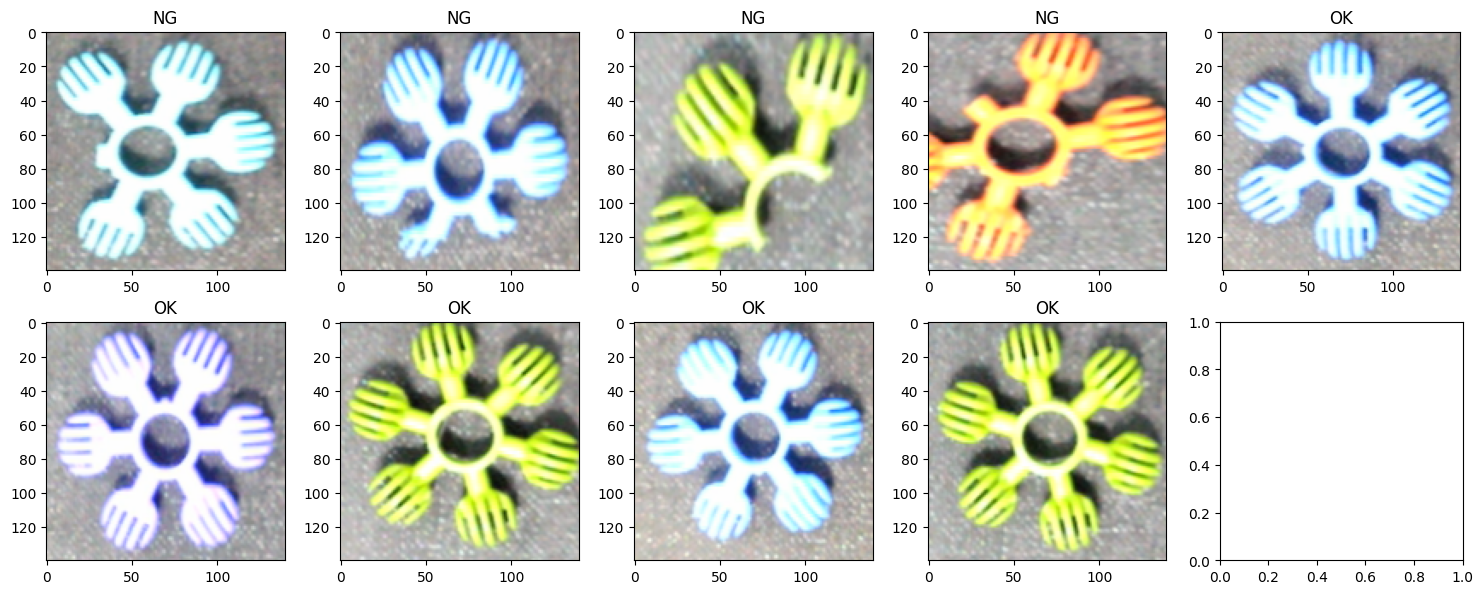

In [21]:
from sklearn.svm import OneClassSVM

clf = OneClassSVM(nu=0.15, kernel='rbf', gamma='auto')
clf.fit(train_predict)

pred_ok = clf.predict(train_predict)
pred_ng = clf.predict(test_predict)
test=pred_ng

pred_ok = np.where(pred_ok < 0,0,1).sum()/train_predict.shape[0]
print("train(%):",pred_ok*100)
pred_ng = np.where(pred_ng < 0,1,0).sum()/test_predict.shape[0]
print("test(%):",pred_ng*100)

# テスト画像と判定結果を表示
num_cols = 5  # 列数
num_rows = int(np.ceil(len(test_predict) / num_cols))  # 必要な行数

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 3*num_rows))

for i in range(len(test_predict)):
    row = i // num_cols
    col = i % num_cols

    if test[i] < 0:
        axes[row, col].imshow(test_img_list[i])  # テスト画像を表示
        axes[row, col].set_title("NG")
    else:
        axes[row, col].imshow(test_img_list[i])  # テスト画像を表示
        axes[row, col].set_title("OK")

plt.tight_layout()
plt.show()
